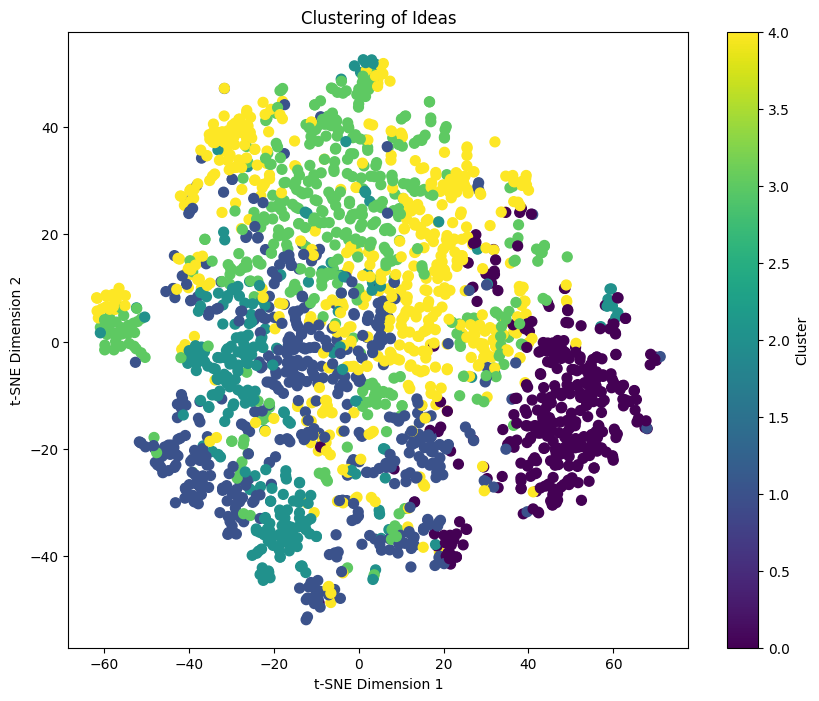

In [11]:
# Import necessary libraries
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pinecone.grpc import PineconeGRPC as Pinecone

# Load environment variables
load_dotenv()

# Set up Pinecone API key and initialize
pinecone_api_key = os.getenv("PINECONE_API_KEY")
if not pinecone_api_key:
    raise ValueError("PINECONE_API_KEY is not set in the .env file")

pc = Pinecone(api_key=pinecone_api_key)

index_name = os.getenv("PINECONE_INDEX_NAME")
namespace = os.getenv("PINECONE_NAMESPACE")
index = pc.Index(index_name)

# Use the describe_index_stats method to get metadata including total vectors
stats = index.describe_index_stats()
vector_count = stats["total_vector_count"]

all_ids = []

for ids in index.list(namespace=namespace):
    all_ids.extend(ids)

embeddings = []

# Step 2: Fetch embeddings in batches
embeddings = []
batch_size = 500

for i in range(0, len(all_ids), batch_size):
    batch_ids = all_ids[i:i + batch_size]
    response = index.fetch(ids=batch_ids, namespace=namespace)
    
    # Extract only the "values" from each vector
    embeddings.extend([vector["values"] for vector in response["vectors"].values()])

# Convert embeddings to a NumPy array
embeddings = np.array(embeddings, dtype=np.float32)  # Ensure data type consistency



# Step 2: Dimensionality reduction
# First, scale the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Use PCA for initial reduction to 50 dimensions (optional)
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Use t-SNE for final 2D visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_embeddings)

# Step 3: Clustering
# Use K-Means to cluster the data
num_clusters = 5  # Adjust this as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(scaled_embeddings)

# Step 4: Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(scatter, label="Cluster")
plt.title("Clustering of Ideas")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
